In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene

from pingouin import anova
from pingouin import welch_anova

from pingouin import pairwise_tukey, pairwise_gameshowell

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [3]:
origin = load_data('head_size')

print("\n===== 데이터 크기 확인=====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인=====
데이터셋 크기: (60, 4)
열 개수: 4
행 개수: 60

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


In [4]:
df = melt(origin, id_vars='측정자번호', value_vars=['1번태아', '2번태아', '3번태아'], var_name='태아번호', value_name='머리둘레')

df.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


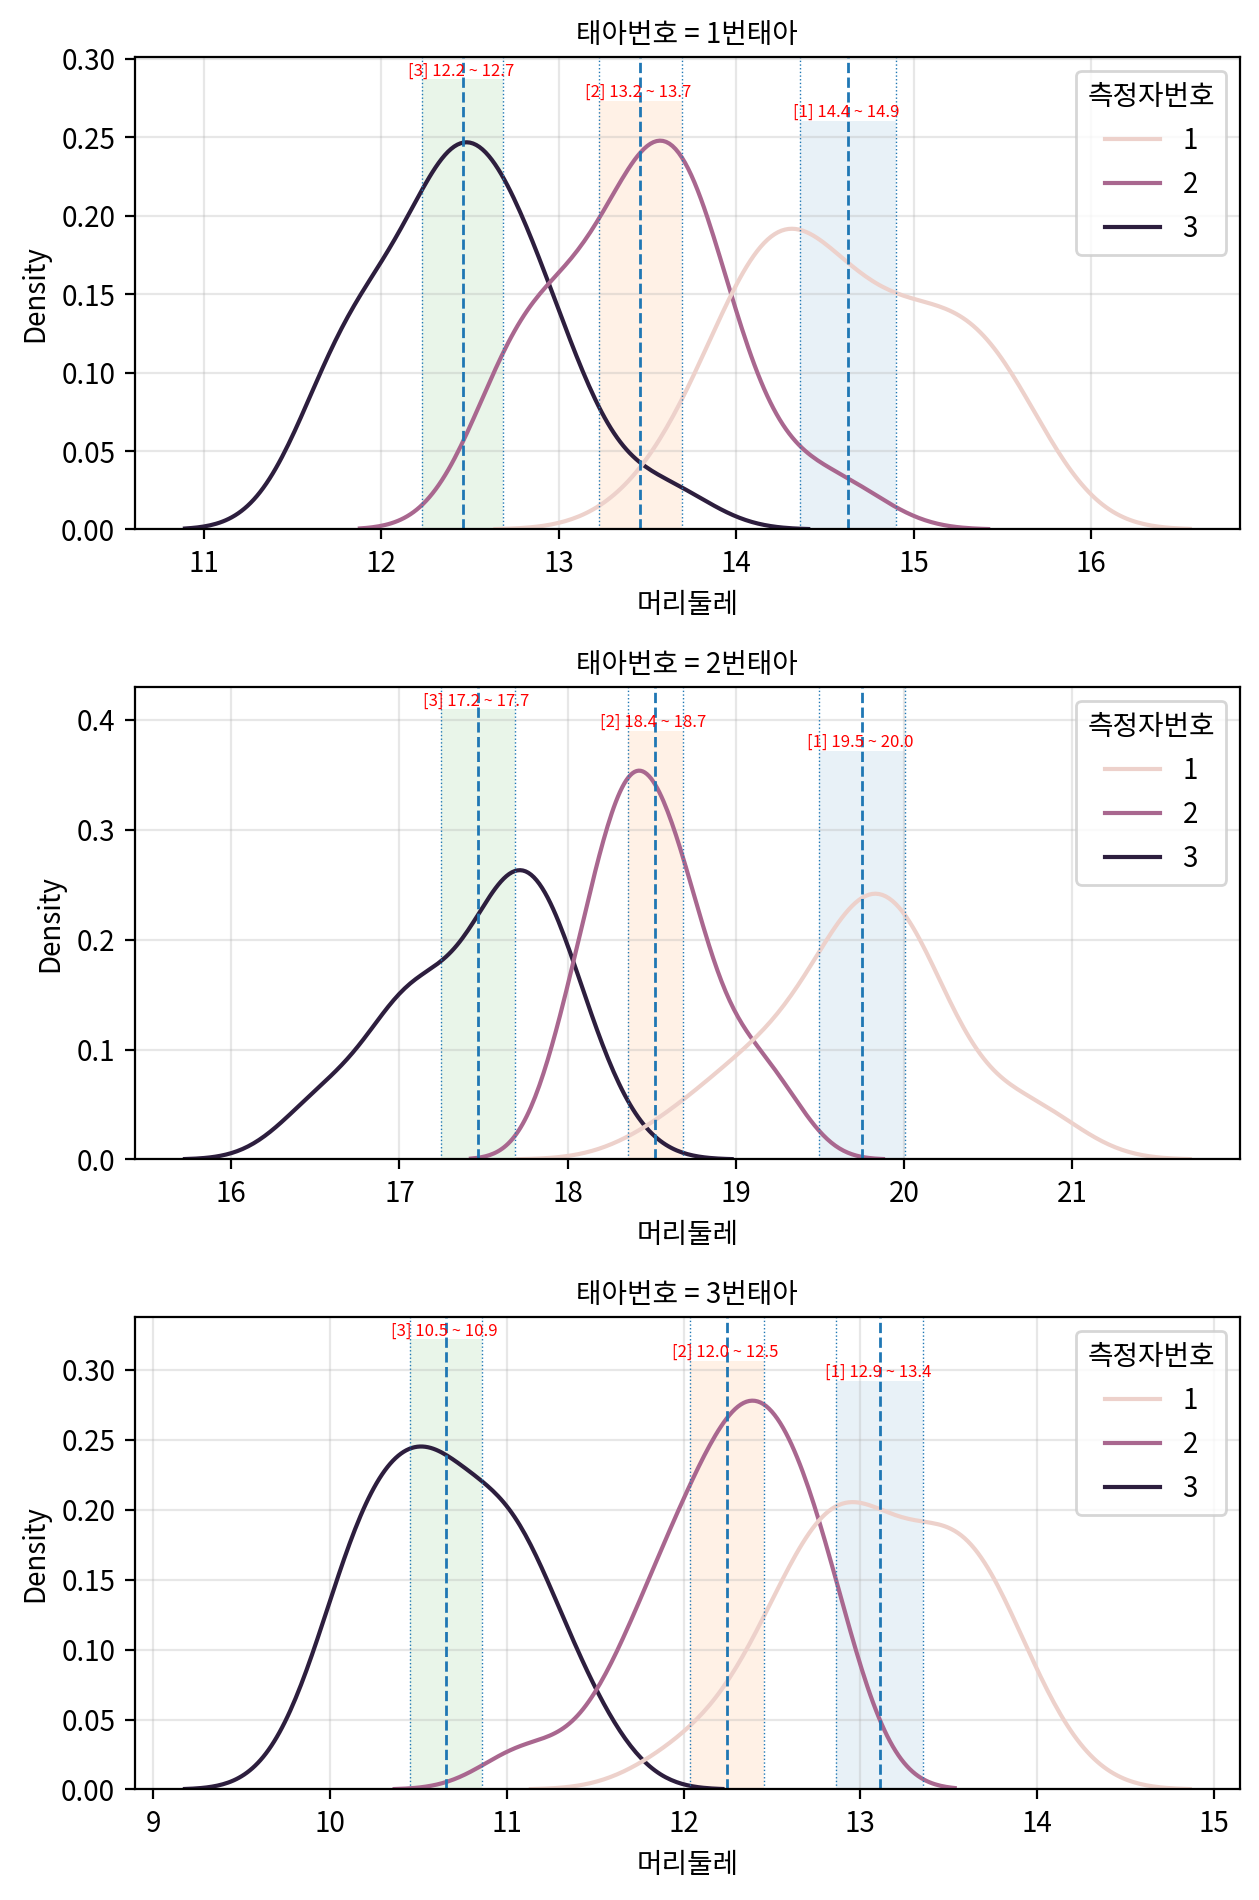

In [6]:
field = '머리둘레'
group_field = '태아번호'
hue_field = '측정자번호'

# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows

figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(group_values):
    temp = data[data[group_field]== v]

    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        max = temp_sub[field].max()
        clevel = 0.95
        dof = len(temp_sub[field]) - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
         s="[%s] %0.1f ~ %0.1f " % (h, cmin, cmax), horizontalalignment="center",
        verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()





가설검정의 가정확인!

In [7]:
data = df.copy()
xname = ['측정자번호', '태아번호']
yname = '머리둘레'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p>0.05
        report.append({
            "field":  "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize


if normal_dist:
    n = "Bartlett"

    s,p = bartlett(*equal_var_fields)

else:
    n = "Levene"

    s,p = levene(*equal_var_fields)

equal_var = p>0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
    })

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


In [8]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname,between=xname)

else: 
    pg_anova = welch_anova(data=data, dv=yname, between=xname)

display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source} 효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source} 효과는 유의하지 않음. (귀무가설 채택: p>0.05)")


,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


-> 측정자번호 효과는 유의함. (대립가설 채택: p<=0.05)
-> 태아번호 효과는 유의함. (대립가설 채택: p<=0.05)
-> 측정자번호 * 태아번호 효과는 유의하지 않음. (귀무가설 채택: p>0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택: p>0.05)


In [10]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals = {}

for index, row in pg_anova.iterrows():      #행을 하나씩 꺼냄!!
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor]<=2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) ->사후검정 수행 안함")
        continue
    print(f"- 주효과 유의 (p={p_val:.3g}) ->사후검정 수행")

    if equal_var:
        print("  Tukey HSD 사용(등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)

    else:
        print("     Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
        display(hoc_df)

interaction_names = [src for src in pvals.keys() if'*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val<=0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g})-> 단순주효과 분석필요")
    else:
        print(f"- 상호작용 유의하지 (p={p_val:.3g})-> 단순주효과 분석필요없음")


[측정자번호]
- 주효과 유의 (p=4.9e-60) ->사후검정 수행
  Tukey HSD 사용(등분산 충족)

[태아번호]
- 주효과 유의 (p=5.62e-134) ->사후검정 수행
  Tukey HSD 사용(등분산 충족)

[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 (p=0.0583)-> 단순주효과 분석필요없음


1.분석 목적
본 분석은 태아의 머리둘레에 대해 관측자와 태아 개체가 어떤영향을 미치는지를 평가하기 위해 이원분산분석을 수행하였다.

2.분산분석 주요 결과
 
측정자번호: p ≤ 0.05 → 유의함(대립가설 채택)
태아번호: p ≤ 0.05 → 유의함(대립가설 채택)
측정자번호 × 태아번호: p > 0.05 → 유의하지 않음(귀무가설 채택)
요약: 측정자에 따라 측정값이 달라지는 경향이 있으며, 태아 간 실제 머리둘레 차이는 매우 크다.
그러나 측정자와 태아의 결합효과(상호작용)는 확인되지 않는다.


3.측정자번호 수준별 평균
-측정자 1: 15.83
-측정자 2: 14.74
-측정자 3: 13.53
→ 관측자마다 평균 측정값이 일관되게 다름.

태아번호 수준별 평균
-1번 태아: 13.52
-2번 태아: 18.58
-3번 태아: 12.00
→ 태아 간 본질적인 머리둘레 차이가 매우 큼.

상호작용 패턴 해석: 모든 관측자가 태아 1·2·3을 측정할 때 비슷한 순서(2번 > 1번 > 3번)를 유지하여
특정 태아에서만 관측자 차이가 갑자기 커지는 양상은 없음.
요약 해석:
평균 패턴이 평행하게 나타나 상호작용 효과가 약함을 시사한다.

4.사후검정결과
(유의수준 α = 0.05 기준으로 “유의함 / 유의하지 않음”만 표시)


측정자번호 (주효과 유의 → 사후검정 실시)
1 vs 3 → 유의함 (p ≤ 0.05)
1 vs 2 → 유의하지 않음 (p > 0.05)
2 vs 3 → 유의하지 않음 (p > 0.05)
→ 측정자 1과 3만 통계적으로 차이가 있음.

태아번호 (주효과 유의 → 사후검정 실시)
2번 > 1번 태아 → 유의함 (p ≤ 0.05)
1번 > 3번 태아 → 유의함 (p ≤ 0.05)
2번 > 3번 태아 → 유의함 (p ≤ 0.05)
→ 모든 태아 간 차이가 명확함.

상호작용:
p > 0.05 → 유의하지 않음 → 단순주효과 분석 불필요
요약 해석:
측정자 간 비교에서는 1–3만 유의하고, 태아 간 비교에서는 모든 쌍이 유의하다.


5.최종 결론 요약
측정자마다 측정값의 편차가 존재하며 주효과가 유의함.
태아 자체의 머리둘레 차이는 매우 크며 모든 쌍에서 뚜렷하게 유의함.
상호작용 효과는 유의하지 않아 특정 관측자가 특정 태아만 과대/과소 측정하는 패턴은 없음.
분산분석과 사후검정 모두 태아 간 개체 차이에 의해 유의하게 달라지지만, 두 요인의 상호작용 효과는 존재하지 않는다.